In [1]:
!pip install VESIcal
import sys
sys.path.append(r'..')
import VESIcal as v
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import pandas as pd
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
%matplotlib inline

In [2]:
sns.set(style="ticks", context="poster",rc={"grid.linewidth": 1,"xtick.major.width": 1,"ytick.major.width": 1, 'patch.edgecolor': 'black'})
plt.style.use("seaborn-colorblind")
plt.rcParams["font.family"] = 'arial'
plt.rcParams["font.size"] =12
#plt.rcParams["mathtext.default"] = "regular"
#plt.rcParams["mathtext.fontset"] = "arial"
plt.rcParams['patch.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1 
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 6 # Sets length of ticks
plt.rcParams["ytick.major.size"] = 4 # Sets length of ticks
plt.rcParams["ytick.labelsize"] = 12 # Sets size of numbers on tick marks
plt.rcParams["xtick.labelsize"] = 12 # Sets size of numbers on tick marks
plt.rcParams["axes.titlesize"] = 12 # Overall title
plt.rcParams["axes.labelsize"] = 12 # Axes labels
plt.rcParams["legend.fontsize"]= 14

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Define some ways to calculate cation fractions etc. 
- Code taken from Thermobar- Wieser et al. in prep

In [3]:
df_ideal_H=pd.DataFrame(columns=['SiO2', 'TiO2', 'Al2O3', 'FeOt',  'MnO', 'MgO',   'CaO', 'Na2O', 'K2O',  'P2O5', 'H2O'])

df_ideal_A=pd.DataFrame(columns=['SiO2', 'TiO2', 'Al2O3', 'FeOt',  'MnO', 'MgO',  'CaO', 'Na2O', 'K2O',  'P2O5'])

cation_num_liq_hyd = {'SiO2': 1, 'MgO': 1, 'MnO':1, 'FeOt': 1,'CaO': 1, 'Al2O3': 2, 'Na2O': 2,
'K2O': 2,  'TiO2': 1, 'P2O5': 2, 'Cr2O3':2,  'H2O':2}
cation_num_liq_hyd_df = pd.DataFrame.from_dict(cation_num_liq_hyd,orient = 'index').T
cation_num_liq_hyd_df['Sample_ID'] = 'CatNum'
cation_num_liq_hyd_df.set_index('Sample_ID',inplace = True)

cation_num_liq_anhyd = {'SiO2': 1, 'MgO': 1, 'MnO':1, 'FeOt': 1,  'CaO': 1, 'Al2O3': 2, 'Na2O': 2,
'K2O': 2,  'TiO2': 1, 'P2O5': 2}
# Turns dictionary into a dataframe so pandas matrix math functions can be used
cation_num_liq_anhyd_df = pd.DataFrame.from_dict(cation_num_liq_anhyd,orient = 'index').T
cation_num_liq_anhyd_df['Sample_ID'] = 'CatNum'
cation_num_liq_anhyd_df.set_index('Sample_ID',inplace = True)

cation_num_liq_anhyd = {'SiO2': 1, 'MgO': 1, 'MnO':1, 'FeOt': 1,   'CaO': 1, 'Al2O3': 2, 'Na2O': 2,
'K2O': 2,  'TiO2': 1, 'P2O5': 2}
# Turns dictionary into a dataframe so pandas matrix math functions can be used
cation_num_liq_anhyd_df = pd.DataFrame.from_dict(cation_num_liq_anhyd,orient = 'index').T
cation_num_liq_anhyd_df['Sample_ID'] = 'CatNum'
cation_num_liq_anhyd_df.set_index('Sample_ID',inplace = True)

oxide_mass_liq_anhyd= {'SiO2': 60.0843, 'MgO': 40.3044, 'MnO': 70.9375, 'FeOt':71.8464, '' 'CaO': 56.0774,
                       'Al2O3': 101.961, 'Na2O': 61.9789, 'K2O': 94.196,  'TiO2': 79.8788, 'P2O5': 141.937}
# Turns dictionary into a dataframe so pandas matrix math functions can be used
oxide_mass_liq_anhyd_df = pd.DataFrame.from_dict(oxide_mass_liq_anhyd,orient = 'index').T
oxide_mass_liq_anhyd_df['Sample_ID'] = 'MolWt'
oxide_mass_liq_anhyd_df.set_index('Sample_ID',inplace = True)

oxide_mass_liq_hyd= {'SiO2': 60.0843, 'MgO': 40.3044, 'MnO': 70.9375,  'FeOt': 71.844, 'CaO': 56.0774, 'Al2O3': 101.961, 'Na2O': 61.9789, 'K2O': 94.196, 'TiO2': 79.8788, 'P2O5': 141.937, 'Cr2O3':151.9982, 'H2O': 18.01528}
# Turns dictionary into a dataframe so pandas matrix math functions can be used
oxide_mass_liq_hyd_df = pd.DataFrame.from_dict(oxide_mass_liq_hyd,orient = 'index').T
oxide_mass_liq_hyd_df['Sample_ID'] = 'MolWt'
oxide_mass_liq_hyd_df.set_index('Sample_ID',inplace = True)

def calculate_anhydrous_mol_proportions_liquid(Liq_Comps): 
    # This makes the input match the columns in the oxide mass dataframe
    liq_wt =Liq_Comps.reindex(oxide_mass_liq_anhyd_df.columns, axis=1).fillna(0)
    # Combine the molecular weight and weight percent dataframes
    liq_wt_combo= pd.concat([oxide_mass_liq_anhyd_df, liq_wt],)
    # Drop the calculation column
    mol_prop_anhyd = liq_wt_combo.div(liq_wt_combo.loc['MolWt',:],axis = 'columns').drop(['MolWt'])
    mol_prop_anhyd.columns = [str(col) + '_mol_prop' for col in mol_prop_anhyd.columns]
    return mol_prop_anhyd


def calculate_anhydrous_mol_fractions_liquid(Liq_Comps):
    
    mol_prop=calculate_anhydrous_mol_proportions_liquid(Liq_Comps)
    mol_prop['sum']=mol_prop.sum(axis='columns')
    mol_frac_anhyd = mol_prop.div(mol_prop['sum'],axis = 'rows')
    mol_frac_anhyd.drop(['sum'],axis = 'columns',inplace = True)
    mol_frac_anhyd.columns = [str(col).replace('prop','frac') for col in mol_frac_anhyd.columns]
    mol_frac_anhyd=pd.concat([Liq_Comps, mol_frac_anhyd], axis=1)
    return mol_frac_anhyd

def calculate_anhydrous_cat_proportions_liquid(Liq_Comps):
  
    mol_prop_no_cat_num=calculate_anhydrous_mol_proportions_liquid(Liq_Comps)
    mol_prop_no_cat_num.columns = [str(col).replace('_mol_prop','') for col in mol_prop_no_cat_num.columns]
    ox_num_reindex=cation_num_liq_anhyd_df.reindex(oxide_mass_liq_anhyd_df.columns, axis=1).fillna(0)
    df_calc_comb=pd.concat([ox_num_reindex, mol_prop_no_cat_num])
    cation_prop_anhyd=df_calc_comb.multiply(df_calc_comb.loc['CatNum',:],axis = 'columns').drop(['CatNum'])
    cation_prop_anhyd.columns =[str(col) + '_cat_prop' for col in cation_prop_anhyd.columns]
    return cation_prop_anhyd

def calculate_anhydrous_cat_fractions_liquid(Liq_Comps):

    cat_prop=calculate_anhydrous_cat_proportions_liquid(Liq_Comps=Liq_Comps)
    mol_prop=calculate_anhydrous_mol_fractions_liquid(Liq_Comps=Liq_Comps)
    cat_prop['sum']=cat_prop.sum(axis='columns')
    cat_frac_anhyd=cat_prop.div(cat_prop['sum'],axis = 'rows')
    cat_frac_anhyd.drop(['sum'],axis = 'columns',inplace = True)
    cat_frac_anhyd.columns = [str(col).replace('prop','frac') for col in cat_frac_anhyd.columns]         
    cat_frac_anhyd=pd.concat([Liq_Comps, mol_prop, cat_frac_anhyd], axis=1)

    return cat_frac_anhyd
    
def calculate_hydrous_mol_proportions_liquid(Liq_Comps):
 
    # This makes the input match the columns in the oxide mass dataframe
    liq_wt =Liq_Comps.reindex(oxide_mass_liq_hyd_df.columns, axis=1).fillna(0)
    # Combine the molecular weight and weight percent dataframes
    liq_wt_combo= pd.concat([oxide_mass_liq_hyd_df, liq_wt],)
    # Drop the calculation column
    mol_prop_hyd = liq_wt_combo.div(liq_wt_combo.loc['MolWt',:],axis = 'columns').drop(['MolWt'])
    mol_prop_hyd.columns = [str(col) + '_mol_prop_hyd' for col in mol_prop_hyd.columns]
    return mol_prop_hyd


def calculate_hydrous_mol_fractions_liquid(Liq_Comps):
     
    mol_prop=calculate_hydrous_mol_proportions_liquid(Liq_Comps)
    mol_prop['sum']=mol_prop.sum(axis='columns')
    mol_frac_hyd = mol_prop.div(mol_prop['sum'],axis = 'rows')
    mol_frac_hyd.drop(['sum'],axis = 'columns',inplace = True)
    mol_frac_hyd.columns = [str(col).replace('prop','frac') for col in mol_frac_hyd.columns]
    mol_frac_hyd=pd.concat([Liq_Comps, mol_frac_hyd], axis=1)
    return mol_frac_hyd

def calculate_hydrous_cat_proportions_liquid(Liq_Comps):
   
    mol_prop_no_cat_num=calculate_hydrous_mol_proportions_liquid(Liq_Comps)
    mol_prop_no_cat_num.columns = [str(col).replace('_mol_prop_hyd','') for col in mol_prop_no_cat_num.columns]
    ox_num_reindex=cation_num_liq_hyd_df.reindex(oxide_mass_liq_hyd_df.columns, axis=1).fillna(0)
    df_calc_comb=pd.concat([ox_num_reindex, mol_prop_no_cat_num])
    cation_prop_hyd=df_calc_comb.multiply(df_calc_comb.loc['CatNum',:],axis = 'columns').drop(['CatNum'])
    cation_prop_hyd.columns =[str(col) + '_cat_prop_hyd' for col in cation_prop_hyd.columns]
    return cation_prop_hyd

def calculate_hydrous_cat_fractions_liquid(Liq_Comps):

    cat_prop=calculate_hydrous_cat_proportions_liquid(Liq_Comps=Liq_Comps)
    mol_prop=calculate_hydrous_mol_fractions_liquid(Liq_Comps=Liq_Comps)
    cat_prop['sum']=cat_prop.sum(axis='columns')
    cat_frac_hyd=cat_prop.div(cat_prop['sum'],axis = 'rows')
    cat_frac_hyd.drop(['sum'],axis = 'columns',inplace = True)
    cat_frac_hyd.columns = [str(col).replace('prop','frac') for col in cat_frac_hyd.columns]         
    cat_frac_hyd=pd.concat([Liq_Comps, mol_prop, cat_frac_hyd], axis=1) 
    return cat_frac_hyd

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Loading Cassidy data - data, my file

In [4]:
Cassidy_MIs = pd.read_excel('Andesite_MIs_Calibration_Data.xlsx', sheet_name='Cassidy_MI')
Cassidy_MIs['FeOt']=Cassidy_MIs['FeOTotalfromMike']
Cassidy_MIs_A_cat_frac=calculate_anhydrous_cat_fractions_liquid(Liq_Comps=Cassidy_MIs)
Cassidy_MIs_H_cat_frac=calculate_hydrous_cat_fractions_liquid(Liq_Comps=Cassidy_MIs)
Cassidy_MIs_A_mol_frac=calculate_anhydrous_mol_fractions_liquid(Liq_Comps=Cassidy_MIs)
Cassidy_MIs_H_mol_frac=calculate_hydrous_mol_fractions_liquid(Liq_Comps=Cassidy_MIs)

Cassidy_MIs_H_cat_frac

Label Label.1  SiO2  TiO2  Al2O3  FeOTotalfromMike     Fe2O3     FeO  \
0   SSH4_1     Pyx  64.6  0.86   16.4              3.98  0.663327  3.3830   
1   SSH4_2     Pyx  63.6  0.59   16.5              3.44  0.573328  2.9240   
2  SSH10_1      Ol  58.7  0.68   15.0              5.57  0.928324  4.7345   
3  SSH5B_1   Pyx_2  67.6  0.48   17.0              0.48  0.079999  0.4080   
4  SSH5B_2     Pyx  67.2  0.70   16.9              0.46  0.076666  0.3910   
5    SSH10      Ol  60.3  0.81   15.8              5.49  0.914991  4.6665   
6    SSH5B     Pyx  68.0  0.41   16.2              1.40  0.233331  1.1900   
7   SSH4_3     Pyx  63.0  0.62   16.0              4.20  0.699993  3.5700   

   MnO   MgO  ...  MnO_cat_frac_hyd  FeOt_cat_frac_hyd  CaO_cat_frac_hyd  \
0    0  0.87  ...               0.0           0.024286          0.035414   
1    0  0.78  ...               0.0           0.021224          0.033514   
2    0  2.36  ...               0.0           0.034347          0.045031   
3    0  0.02  ...               0.0           0.002791          0.023389   
4    0  0.02  ...               0.0           0.002770          0.025532   
5    0  2.80  ...               0.0           0.034218          0.052383   
6    0  0.60  ...               0.0           0.008235          0.031652   
7    0  1.10  ...               0.0           0.026282          0.034473   

   Al2O3_cat_frac_hyd  Na2O_cat_frac_hyd  K2O_cat_frac_hyd  TiO2_cat_frac_hyd  \
0            0.141026           0.057717          0.009773           0.004720   
1            0.143461           0.061648          0.009129           0.003274   
2            0.130351           0.030450          0.020882           0.003771   
3            0.139290           0.060791          0.014013           0.002510   
4            0.143391           0.062672          0.014695           0.003791   
5            0.138779           0.028032          0.003042           0.004541   
6            0.134294           0.057277          0.014357           0.002169   
7            0.141095           0.047874          0.008591           0.003489   

   P2O5_cat_frac_hyd  Cr2O3_cat_frac_hyd  H2O_cat_frac_hyd  
0                0.0                 0.0          0.246263  
1                0.0                 0.0          0.249981  
2                0.0                 0.0          0.276409  
3                0.0                 0.0          0.287048  
4                0.0                 0.0          0.263154  
5                0.0                 0.0          0.258502  
6                0.0                 0.0          0.267430  
7                0.0                 0.0          0.254540  

[8 rows x 74 columns]

# Loading Atlas stuff - Myfile4, data4

In [5]:
########################### Anhydrous calculation
Atlas_MIs =  pd.read_excel('Andesite_MIs_Calibration_Data.xlsx', sheet_name='Atlas_MI')
Atlas_MIs['FeOt']=Atlas_MIs['FeOTotalasPublished']
Atlas_MIs_A_cat_frac=calculate_anhydrous_cat_fractions_liquid(Liq_Comps=Atlas_MIs)
Atlas_MIs_H_cat_frac=calculate_hydrous_cat_fractions_liquid(Liq_Comps=Atlas_MIs)
Atlas_MIs_A_mol_frac=calculate_anhydrous_mol_fractions_liquid(Liq_Comps=Atlas_MIs)
Atlas_MIs_H_mol_frac=calculate_hydrous_mol_fractions_liquid(Liq_Comps=Atlas_MIs)

Atlas_MIs_H_cat_frac.head()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Label    SiO2   TiO2   Al2O3    MnO    MgO  FeOTotalasPublished      FeO  \
0        1  70.807  0.784  14.559  0.039  0.574                2.750  2.33750   
1  Sample2  72.383  0.662  14.930  0.032  0.582                2.566  2.18110   
2        3  72.090  0.639  14.377  0.045  0.537                2.438  2.07230   
3        4  63.168  1.091  13.532  0.106  1.994                5.257  4.46845   
4        5  64.926  0.883  13.950  0.072  1.541                3.858  3.27930   

      Fe2O3    CaO  ...  MnO_cat_frac_hyd  FeOt_cat_frac_hyd  \
0  0.458329  1.896  ...          0.000298           0.020766   
1  0.427662  2.010  ...          0.000243           0.019204   
2  0.406329  1.839  ...          0.000347           0.018560   
3  0.876158  4.897  ...          0.000810           0.039653   
4  0.642994  3.528  ...          0.000557           0.029458   

   CaO_cat_frac_hyd  Al2O3_cat_frac_hyd  Na2O_cat_frac_hyd  K2O_cat_frac_hyd  \
0          0.018343            0.154934           0.032316          0.031401   
1          0.019272            0.157460           0.027764          0.024476   
2          0.017936            0.154242           0.028579          0.031413   
3          0.047323            0.143843           0.035698          0.010965   
4          0.034512            0.150108           0.043150          0.023062   

   TiO2_cat_frac_hyd  P2O5_cat_frac_hyd  Cr2O3_cat_frac_hyd  H2O_cat_frac_hyd  
0           0.005325           0.001009                 0.0          0.088537  
1           0.004456           0.000909                 0.0          0.090729  
2           0.004375           0.000886                 0.0          0.080150  
3           0.007402           0.004062                 0.0          0.113706  
4           0.006064           0.002504                 0.0          0.096832  

[5 rows x 70 columns]

# calculating cation fracs for Shishkina H2O dataset

In [6]:
########################### Anhydrous calculation
Shish_H2O =  pd.read_excel('Andesite_MIs_Calibration_Data.xlsx', sheet_name='Shishkina_Cali_H2Oonly')
Shish_H2O['FeOt']=Shish_H2O['FeO']+0.8998*Shish_H2O['Fe2O3']
Shish_H2O_A_cat_frac=calculate_anhydrous_cat_fractions_liquid(Liq_Comps=Shish_H2O)
Shish_H2O_H_cat_frac=calculate_hydrous_cat_fractions_liquid(Liq_Comps=Shish_H2O)
Shish_H2O_A_mol_frac=calculate_anhydrous_mol_fractions_liquid(Liq_Comps=Shish_H2O)
Shish_H2O_H_mol_frac=calculate_hydrous_mol_fractions_liquid(Liq_Comps=Shish_H2O)

Shish_H2O_H_cat_frac.head()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Reference       SiO2      TiO2      Al2O3  Fe2O3        FeO  \
0  Shishkina et al., 2010  50.175018  0.920092  18.281828    0.0   9.370937   
1  Shishkina et al., 2010  50.175018  0.920092  18.281828    0.0   9.370937   
2              This study  46.237383  2.700445  14.656611    0.0  11.751120   
3              This study  47.327420  2.353128  14.179890    0.0  10.825606   
4              This study  43.666155  2.638655  12.659386    0.0  11.548572   

        MnO        MgO        CaO      Na2O  ...  MnO_cat_frac_hyd  \
0  0.170017   7.000700  11.371137  2.330233  ...          0.001334   
1  0.170017   7.000700  11.371137  2.330233  ...          0.001334   
2  0.164913   8.719756  10.636866  3.514701  ...          0.001287   
3  0.173174  10.370063   9.942222  3.524599  ...          0.001341   
4  0.195076  12.074159  11.827748  3.685904  ...          0.001501   

   FeOt_cat_frac_hyd  CaO_cat_frac_hyd  Al2O3_cat_frac_hyd Na2O_cat_frac_hyd  \
0           0.072597          0.112860            0.199591          0.041852   
1           0.072597          0.112860            0.199591          0.041852   
2           0.090539          0.104996            0.159139          0.062780   
3           0.082744          0.097357            0.152736          0.062455   
4           0.087732          0.115116            0.135528          0.064916   

   K2O_cat_frac_hyd  TiO2_cat_frac_hyd  P2O5_cat_frac_hyd  Cr2O3_cat_frac_hyd  \
0          0.002718           0.006411           0.001177                 0.0   
1          0.002718           0.006411           0.001177                 0.0   
2          0.012477           0.018713           0.004341                 0.0   
3          0.009739           0.016177           0.003626                 0.0   
4          0.011660           0.018029           0.005369                 0.0   

   H2O_cat_frac_hyd  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  

[5 rows x 52 columns]

In [7]:
########################### Anhydrous calculation
########################### Anhydrous calculation
Shish_mixed =  pd.read_excel('Andesite_MIs_Calibration_Data.xlsx', sheet_name='Shishkina_Cali_mixed_CO2')
Shish_mixed['FeOt']=Shish_mixed['FeO']+0.8998*Shish_mixed['Fe2O3']
Shish_mixed_A_cat_frac=calculate_anhydrous_cat_fractions_liquid(Liq_Comps=Shish_mixed)
Shish_mixed_H_cat_frac=calculate_hydrous_cat_fractions_liquid(Liq_Comps=Shish_mixed)
Shish_mixed_A_mol_frac=calculate_anhydrous_mol_fractions_liquid(Liq_Comps=Shish_mixed)
Shish_mixed_H_mol_frac=calculate_hydrous_mol_fractions_liquid(Liq_Comps=Shish_mixed)

Shish_mixed_H_cat_frac.head()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Reference       SiO2      TiO2      Al2O3  Fe2O3        FeO  \
0  Shishkina et al., 2010  50.175018  0.920092  18.281828    0.0   9.370937   
1              This study  47.327420  2.353128  14.179890    0.0  10.825606   
2              This study  43.666155  2.638655  12.659386    0.0  11.548572   
3              This study  42.355137  2.260615  11.805435    0.0  11.009208   
4              This study  48.342182  1.773014  16.397876    0.0  10.477812   

        MnO        MgO        CaO      Na2O  ...  MnO_cat_frac_hyd  \
0  0.170017   7.000700  11.371137  2.330233  ...          0.001334   
1  0.173174  10.370063   9.942222  3.524599  ...          0.001341   
2  0.195076  12.074159  11.827748  3.685904  ...          0.001501   
3  0.188385  13.322978  13.239251  3.725829  ...          0.001440   
4  0.200341   5.970149  10.828408  3.455875  ...          0.001569   

   FeOt_cat_frac_hyd  CaO_cat_frac_hyd  Al2O3_cat_frac_hyd  Na2O_cat_frac_hyd  \
0           0.072597          0.112860            0.199591           0.041852   
1           0.082744          0.097357            0.152736           0.062455   
2           0.087732          0.115116            0.135528           0.064916   
3           0.083104          0.128035            0.125583           0.065202   
4           0.081030          0.107286            0.178710           0.061960   

  K2O_cat_frac_hyd  TiO2_cat_frac_hyd  P2O5_cat_frac_hyd  Cr2O3_cat_frac_hyd  \
0         0.002718           0.006411           0.001177                 0.0   
1         0.009739           0.016177           0.003626                 0.0   
2         0.011660           0.018029           0.005369                 0.0   
3         0.011087           0.015348           0.008637                 0.0   
4         0.023161           0.012332           0.004627                 0.0   

   H2O_cat_frac_hyd  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  

[5 rows x 54 columns]

# Calculating cation fractions for IaconoMArziano water data

In [8]:
########################### Anhydrous calculation
IM_H2O =  pd.read_excel('Andesite_MIs_Calibration_Data.xlsx', sheet_name='IM_H2O_CO2')
IM_H2O['FeOt']=IM_H2O['FeOT']
IM_H2O_A_cat_frac=calculate_anhydrous_cat_fractions_liquid(Liq_Comps=IM_H2O)
IM_H2O_H_cat_frac=calculate_hydrous_cat_fractions_liquid(Liq_Comps=IM_H2O)
IM_H2O_A_mol_frac=calculate_anhydrous_mol_fractions_liquid(Liq_Comps=IM_H2O)
IM_H2O_H_mol_frac=calculate_hydrous_mol_fractions_liquid(Liq_Comps=IM_H2O)

IM_H2O_H_cat_frac.head()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Label   SiO2  TiO2  Al2O3  FeOT   MgO   CaO  Na2O   K2O  P2O5  ...  \
0      1  48.86  1.73  16.77  9.71  6.65  9.86  3.62  1.93  0.68  ...   
1      2  48.86  1.73  16.77  9.71  6.65  9.86  3.62  1.93  0.68  ...   
2      3  48.86  1.73  16.77  9.71  6.65  9.86  3.62  1.93  0.68  ...   
3      4  48.86  1.73  16.77  9.71  6.65  9.86  3.62  1.93  0.68  ...   
4      5  48.86  1.73  16.77  9.71  6.65  9.86  3.62  1.93  0.68  ...   

   MnO_cat_frac_hyd  FeOt_cat_frac_hyd  CaO_cat_frac_hyd  Al2O3_cat_frac_hyd  \
0               0.0           0.060604          0.078842            0.147503   
1               0.0           0.056974          0.074120            0.138667   
2               0.0           0.058704          0.076371            0.142880   
3               0.0           0.057566          0.074891            0.140110   
4               0.0           0.065813          0.085619            0.160181   

   Na2O_cat_frac_hyd  K2O_cat_frac_hyd  TiO2_cat_frac_hyd  P2O5_cat_frac_hyd  \
0           0.052380          0.018375           0.009711           0.004296   
1           0.049242          0.017274           0.009130           0.004039   
2           0.050738          0.017799           0.009407           0.004162   
3           0.049755          0.017454           0.009225           0.004081   
4           0.056882          0.019954           0.010546           0.004666   

   Cr2O3_cat_frac_hyd  H2O_cat_frac_hyd  
0                 0.0          0.189664  
1                 0.0          0.238205  
2                 0.0          0.215063  
3                 0.0          0.230280  
4                 0.0          0.120012  

[5 rows x 52 columns]

In [9]:
###  Loading Andesite experimental stuff

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
########################### Anhydrous calculation
Exp =  pd.read_excel(r'../Figure_16_Intermediate_Isobars/AndesiteIsobars_VESIcal_In_2021.xlsx', sheet_name='BulkCompositions_hydrous')
Exp=Exp.fillna(0)
Exp['FeOt']=Exp['FeO']+0.8998*Exp['Fe2O3']
Exp_A_cat_frac=calculate_anhydrous_cat_fractions_liquid(Liq_Comps=Exp)
Exp_H_cat_frac=calculate_hydrous_cat_fractions_liquid(Liq_Comps=Exp)
Exp_A_mol_frac=calculate_anhydrous_mol_fractions_liquid(Liq_Comps=Exp)
Exp_H_mol_frac=calculate_hydrous_mol_fractions_liquid(Liq_Comps=Exp)
Exp_H_mol_frac.head()


/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Label    SiO2      TiO2      Al2O3  Fe2O3       FeO  \
0      Bot_2006_MinWater  57.440  1.060000  17.530000    0.0  7.200000   
1      Bot_2006_MaxWater  57.440  1.060000  17.530000    0.0  7.200000   
2  Berhens_2004_MinWater  65.840  0.660000  15.440000    0.0  4.730000   
3  Berhens_2004_MaxWater  65.840  0.660000  15.440000    0.0  4.730000   
4     King_2002_MinWater  58.415  0.876667  17.818333    0.0  5.403838   

        MnO   MgO       CaO      Na2O  ...  MnO_mol_frac_hyd  \
0  0.120000  4.31  7.420000  3.320000  ...          0.001058   
1  0.120000  4.31  7.420000  3.320000  ...          0.000803   
2  0.070000  2.14  4.890000  3.680000  ...          0.000625   
3  0.070000  2.14  4.890000  3.680000  ...          0.000512   
4  0.083333  2.81  5.808333  4.543333  ...          0.000788   

   FeOt_mol_frac_hyd  CaO_mol_frac_hyd  Al2O3_mol_frac_hyd  Na2O_mol_frac_hyd  \
0           0.062672          0.082746            0.107517           0.033498   
1           0.047564          0.062799            0.081599           0.025423   
2           0.041680          0.055205            0.095867           0.037589   
3           0.034174          0.045264            0.078603           0.030820   
4           0.050460          0.069486            0.117237           0.049177   

   K2O_mol_frac_hyd  TiO2_mol_frac_hyd  P2O5_mol_frac_hyd  Cr2O3_mol_frac_hyd  \
0          0.010689           0.008299                0.0                 0.0   
1          0.008112           0.006298                0.0                 0.0   
2          0.017138           0.005231                0.0                 0.0   
3          0.014052           0.004289                0.0                 0.0   
4          0.006493           0.007363                0.0                 0.0   

   H2O_mol_frac_hyd  
0          0.028812  
1          0.262923  
2          0.019328  
3          0.195928  
4          0.000000  

[5 rows x 27 columns]

# Loading North Arch Lavas

In [13]:
v.BatchFile('Andesite_MIs_Calibration_Data.xlsx', sheet_name=' North_Arch_Lavas', input_type='wtpercent')
NorthArch =  pd.read_excel('Andesite_MIs_Calibration_Data.xlsx', sheet_name=' North_Arch_Lavas')
NorthArch=NorthArch.fillna(0)
NorthArch['FeOt']=NorthArch['FeO']+0.8998*NorthArch['Fe2O3']
NorthArch_A_cat_frac=calculate_anhydrous_cat_fractions_liquid(Liq_Comps=NorthArch)
NorthArch_H_cat_frac=calculate_hydrous_cat_fractions_liquid(Liq_Comps=NorthArch)
NorthArch_A_mol_frac=calculate_anhydrous_mol_fractions_liquid(Liq_Comps=NorthArch)
NorthArch_H_mol_frac=calculate_hydrous_mol_fractions_liquid(Liq_Comps=NorthArch)

NorthArch_H_cat_frac.head()


/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Label  SiO2  Al2O3  Fe2O3   FeO   MnO   MgO   CaO  Na2O   K2O  ...  \
0  North Arch 1  43.6   14.5      0  11.7  0.19  7.01  13.2  3.97  1.12  ...   
1  North Arch 2  43.4   13.9      0  12.0  0.19  7.89  12.2  4.06  0.97  ...   
2  North Arch 3  44.9   14.6      0  11.8  0.18  7.55  12.3  3.81  0.85  ...   
3  North Arch 4  46.0   14.6      0  11.3  0.19  7.33  12.4  3.55  0.74  ...   
4  North Arch 5  45.0   14.2      0  11.4  0.16  8.71  11.6  3.44  0.78  ...   

   MnO_cat_frac_hyd  FeOt_cat_frac_hyd  CaO_cat_frac_hyd  Al2O3_cat_frac_hyd  \
0          0.001420           0.086319          0.124767            0.150757   
1          0.001394           0.086901          0.113190            0.141855   
2          0.001349           0.087293          0.116575            0.152208   
3          0.001424           0.083609          0.117543            0.152234   
4          0.001204           0.084687          0.110401            0.148657   

   Na2O_cat_frac_hyd  K2O_cat_frac_hyd  TiO2_cat_frac_hyd  P2O5_cat_frac_hyd  \
0           0.067903          0.012605           0.015660           0.003734   
1           0.068163          0.010715           0.014590           0.003519   
2           0.065343          0.009592           0.014372           0.002846   
3           0.060894          0.008352           0.012511           0.002547   
4           0.059244          0.008839           0.012628           0.002406   

   Cr2O3_cat_frac_hyd H2O_cat_frac_hyd  
0                 0.0         0.060021  
1                 0.0         0.082019  
2                 0.0         0.053693  
3                 0.0         0.057243  
4                 0.0         0.056880  

[5 rows x 62 columns]

# Calculating Pi

In [14]:
Pi_NorthArch=-6.5*(NorthArch_A_cat_frac['SiO2_cat_frac']+NorthArch_A_cat_frac['Al2O3_cat_frac'])+20.17*(NorthArch_A_cat_frac['CaO_cat_frac']+0.8*NorthArch_A_cat_frac['K2O_cat_frac']+0.7*NorthArch_A_cat_frac['Na2O_cat_frac']+0.4*NorthArch_A_cat_frac['MgO_cat_frac']+0.4*NorthArch_A_cat_frac['FeOt_cat_frac'])
Pi_Exp=-6.5*(Exp_A_cat_frac['SiO2_cat_frac']+Exp_A_cat_frac['Al2O3_cat_frac'])+20.17*(Exp_A_cat_frac['CaO_cat_frac']+0.8*Exp_A_cat_frac['K2O_cat_frac']+0.7*Exp_A_cat_frac['Na2O_cat_frac']+0.4*Exp_A_cat_frac['MgO_cat_frac']+0.4*Exp_A_cat_frac['FeOt_cat_frac'])
Pi_Atlas_MIs=-6.5*(Atlas_MIs_A_cat_frac['SiO2_cat_frac']+Atlas_MIs_A_cat_frac['Al2O3_cat_frac'])+20.17*(Atlas_MIs_A_cat_frac['CaO_cat_frac']+0.8*Atlas_MIs_A_cat_frac['K2O_cat_frac']+0.7*Atlas_MIs_A_cat_frac['Na2O_cat_frac']+0.4*Atlas_MIs_A_cat_frac['MgO_cat_frac']+0.4*Atlas_MIs_A_cat_frac['FeOt_cat_frac'])
Pi_Cassidy_MIs=-6.5*(Cassidy_MIs_A_cat_frac['SiO2_cat_frac']+Cassidy_MIs_A_cat_frac['Al2O3_cat_frac'])+20.17*(Cassidy_MIs_A_cat_frac['CaO_cat_frac']+0.8*Cassidy_MIs_A_cat_frac['K2O_cat_frac']+0.7*Cassidy_MIs_A_cat_frac['Na2O_cat_frac']+0.4*Cassidy_MIs_A_cat_frac['MgO_cat_frac']+0.4*Cassidy_MIs_A_cat_frac['FeOt_cat_frac'])
Pi_Shish_mixed=-6.5*(Shish_mixed_A_cat_frac['SiO2_cat_frac']+Shish_mixed_A_cat_frac['Al2O3_cat_frac'])+20.17*(Shish_mixed_A_cat_frac['CaO_cat_frac']+0.8*Shish_mixed_A_cat_frac['K2O_cat_frac']+0.7*Shish_mixed_A_cat_frac['Na2O_cat_frac']+0.4*Shish_mixed_A_cat_frac['MgO_cat_frac']+0.4*Shish_mixed_A_cat_frac['FeOt_cat_frac'])


/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Calculating Pi*

In [15]:
Pistar_NorthArch=(NorthArch_A_cat_frac['CaO_cat_frac']+0.8*NorthArch_A_cat_frac['K2O_cat_frac']+0.7*NorthArch_A_cat_frac['Na2O_cat_frac']+0.4*NorthArch_A_cat_frac['MgO_cat_frac']
                  +0.4*NorthArch_A_cat_frac['FeOt_cat_frac'])/(NorthArch_A_cat_frac['SiO2_cat_frac']+NorthArch_A_cat_frac['Al2O3_cat_frac'])

Pistar_Exp=(Exp_A_cat_frac['CaO_cat_frac']+0.8*Exp_A_cat_frac['K2O_cat_frac']+0.7*Exp_A_cat_frac['Na2O_cat_frac']+0.4*Exp_A_cat_frac['MgO_cat_frac']
            +0.4*Exp_A_cat_frac['FeOt_cat_frac'])/(Exp_A_cat_frac['SiO2_cat_frac']+Exp_A_cat_frac['Al2O3_cat_frac'])

Pistar_Cassidy_MIs=(Cassidy_MIs_A_cat_frac['CaO_cat_frac']+0.8*Cassidy_MIs_A_cat_frac['K2O_cat_frac']+0.7*Cassidy_MIs_A_cat_frac['Na2O_cat_frac']+0.4*Cassidy_MIs_A_cat_frac['MgO_cat_frac']
            +0.4*Cassidy_MIs_A_cat_frac['FeOt_cat_frac'])/(Cassidy_MIs_A_cat_frac['SiO2_cat_frac']+Cassidy_MIs_A_cat_frac['Al2O3_cat_frac'])

Pistar_Atlas_MIs=(Atlas_MIs_A_cat_frac['CaO_cat_frac']+0.8*Atlas_MIs_A_cat_frac['K2O_cat_frac']+0.7*Atlas_MIs_A_cat_frac['Na2O_cat_frac']+0.4*Atlas_MIs_A_cat_frac['MgO_cat_frac']
            +0.4*Atlas_MIs_A_cat_frac['FeOt_cat_frac'])/(Atlas_MIs_A_cat_frac['SiO2_cat_frac']+Atlas_MIs_A_cat_frac['Al2O3_cat_frac'])

Pistar_Shish_mixed=(Shish_mixed_A_cat_frac['CaO_cat_frac']+0.8*Shish_mixed_A_cat_frac['K2O_cat_frac']+0.7*Shish_mixed_A_cat_frac['Na2O_cat_frac']+0.4*Shish_mixed_A_cat_frac['MgO_cat_frac']
            +0.4*Shish_mixed_A_cat_frac['FeOt_cat_frac'])/(Shish_mixed_A_cat_frac['SiO2_cat_frac']+Shish_mixed_A_cat_frac['Al2O3_cat_frac'])

# Calculating NBO/O anhydrous (as interested in behavoir at a range of water contents)

In [16]:


IM_H2O_NBO=2*(IM_H2O_A_mol_frac['K2O_mol_frac']+IM_H2O_A_mol_frac['Na2O_mol_frac']+IM_H2O_A_mol_frac['CaO_mol_frac']
                 +IM_H2O_A_mol_frac['MgO_mol_frac']+IM_H2O_A_mol_frac['FeOt_mol_frac']-IM_H2O_A_mol_frac['Al2O3_mol_frac'])
IM_H2O_O=(2*IM_H2O_A_mol_frac['SiO2_mol_frac']+2*IM_H2O_A_mol_frac['TiO2_mol_frac']+3*IM_H2O_A_mol_frac['Al2O3_mol_frac']
             +IM_H2O_A_mol_frac['MgO_mol_frac']+IM_H2O_A_mol_frac['FeOt_mol_frac']+IM_H2O_A_mol_frac['CaO_mol_frac']
             +IM_H2O_A_mol_frac['Na2O_mol_frac']+IM_H2O_A_mol_frac['K2O_mol_frac'])
NBOO_IM_H2O=IM_H2O_NBO/IM_H2O_O

Exp_NBO=2*(Exp_A_mol_frac['K2O_mol_frac']+Exp_A_mol_frac['Na2O_mol_frac']+Exp_A_mol_frac['CaO_mol_frac']
                 +Exp_A_mol_frac['MgO_mol_frac']+Exp_A_mol_frac['FeOt_mol_frac']-Exp_A_mol_frac['Al2O3_mol_frac'])
Exp_O=(2*Exp_A_mol_frac['SiO2_mol_frac']+2*Exp_A_mol_frac['TiO2_mol_frac']+3*Exp_A_mol_frac['Al2O3_mol_frac']
             +Exp_A_mol_frac['MgO_mol_frac']+Exp_A_mol_frac['FeOt_mol_frac']+Exp_A_mol_frac['CaO_mol_frac']
             +Exp_A_mol_frac['Na2O_mol_frac']+Exp_A_mol_frac['K2O_mol_frac'])
NBOO_Exp=Exp_NBO/Exp_O

Atlas_MIs_NBO=2*(Atlas_MIs_A_mol_frac['K2O_mol_frac']+Atlas_MIs_A_mol_frac['Na2O_mol_frac']+Atlas_MIs_A_mol_frac['CaO_mol_frac']
                 +Atlas_MIs_A_mol_frac['MgO_mol_frac']+Atlas_MIs_A_mol_frac['FeOt_mol_frac']-Atlas_MIs_A_mol_frac['Al2O3_mol_frac'])
Atlas_MIs_O=(2*Atlas_MIs_A_mol_frac['SiO2_mol_frac']+2*Atlas_MIs_A_mol_frac['TiO2_mol_frac']+3*Atlas_MIs_A_mol_frac['Al2O3_mol_frac']
             +Atlas_MIs_A_mol_frac['MgO_mol_frac']+Atlas_MIs_A_mol_frac['FeOt_mol_frac']+Atlas_MIs_A_mol_frac['CaO_mol_frac']
             +Atlas_MIs_A_mol_frac['Na2O_mol_frac']+Atlas_MIs_A_mol_frac['K2O_mol_frac'])
NBOO_Atlas_MIs=Atlas_MIs_NBO/Atlas_MIs_O

Cassidy_MIs_NBO=2*(Cassidy_MIs_A_mol_frac['K2O_mol_frac']+Cassidy_MIs_A_mol_frac['Na2O_mol_frac']+Cassidy_MIs_A_mol_frac['CaO_mol_frac']
                 +Cassidy_MIs_A_mol_frac['MgO_mol_frac']+Cassidy_MIs_A_mol_frac['FeOt_mol_frac']-Cassidy_MIs_A_mol_frac['Al2O3_mol_frac'])
Cassidy_MIs_O=(2*Cassidy_MIs_A_mol_frac['SiO2_mol_frac']+2*Cassidy_MIs_A_mol_frac['TiO2_mol_frac']+3*Cassidy_MIs_A_mol_frac['Al2O3_mol_frac']
             +Cassidy_MIs_A_mol_frac['MgO_mol_frac']+Cassidy_MIs_A_mol_frac['FeOt_mol_frac']+Cassidy_MIs_A_mol_frac['CaO_mol_frac']
             +Cassidy_MIs_A_mol_frac['Na2O_mol_frac']+Cassidy_MIs_A_mol_frac['K2O_mol_frac'])
NBOO_Cassidy_MIs=Cassidy_MIs_NBO/Cassidy_MIs_O

# AI index

In [17]:
Exp_AI=Exp_A_mol_frac['Al2O3_mol_frac']/(Exp_A_mol_frac['CaO_mol_frac']
                                         +Exp_A_mol_frac['Na2O_mol_frac']+
                                        Exp_A_mol_frac['K2O_mol_frac'])

Atlas_MIs_AI=Atlas_MIs_A_mol_frac['Al2O3_mol_frac']/(Atlas_MIs_A_mol_frac['CaO_mol_frac']
                                         +Atlas_MIs_A_mol_frac['Na2O_mol_frac']+
                                        Atlas_MIs_A_mol_frac['K2O_mol_frac'])

Cassidy_MIs_AI=Cassidy_MIs_A_mol_frac['Al2O3_mol_frac']/(Cassidy_MIs_A_mol_frac['CaO_mol_frac']
                                         +Cassidy_MIs_A_mol_frac['Na2O_mol_frac']+
                                        Cassidy_MIs_A_mol_frac['K2O_mol_frac'])

IM_H2O_AI=IM_H2O_A_mol_frac['Al2O3_mol_frac']/(IM_H2O_A_mol_frac['CaO_mol_frac']
                                         +IM_H2O_A_mol_frac['Na2O_mol_frac']+
                                        IM_H2O_A_mol_frac['K2O_mol_frac'])

# Plot of compositional space

<>:62: DeprecationWarning: invalid escape sequence \P
<>:63: DeprecationWarning: invalid escape sequence \P
<>:62: DeprecationWarning: invalid escape sequence \P
<>:63: DeprecationWarning: invalid escape sequence \P
<ipython-input-18-1cdeac46fbcd>:62: DeprecationWarning: invalid escape sequence \P
  ax1.set_ylabel('$\Pi^{*}$ (Shishkina)')
<ipython-input-18-1cdeac46fbcd>:63: DeprecationWarning: invalid escape sequence \P
  ax2.set_ylabel('$\Pi$ (Dixon)')
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


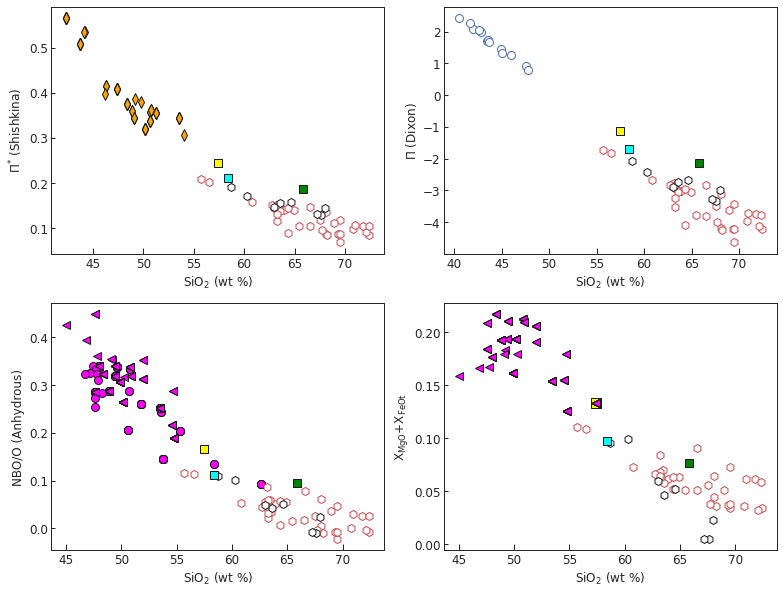

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (13, 10)) #, sharex=ax1, ax2, ax3, sharey=True) # adjust dimensions of figure here
ax1.plot(Shish_mixed['SiO2'], Pistar_Shish_mixed, 'dk', mfc='orange', ms=8)
ax1.plot(Atlas_MIs['SiO2'], Pistar_Atlas_MIs, 'hr', mfc='white', ms=8)
ax1.plot(Cassidy_MIs['SiO2'], Pistar_Cassidy_MIs, 'hk', mfc='white', ms=8)
ax1.plot(Exp.loc[Exp['Label']=="Bot_2006_MinWater", "SiO2"], Pistar_Exp.loc[Exp['Label']=="Bot_2006_MinWater"],
         'sk', mfc='yellow', ms=8)
ax1.plot(Exp.loc[Exp['Label']=="King_2002_MinWater", "SiO2"], Pistar_Exp.loc[Exp['Label']=="King_2002_MinWater"],
         'sk', mfc='cyan', ms=8)
ax1.plot(Exp.loc[Exp['Label']=="Berhens_2004_MinWater", "SiO2"], Pistar_Exp.loc[Exp['Label']=="Berhens_2004_MinWater"],
         'sk', mfc='green', ms=8)

ax2.plot(NorthArch['SiO2'], Pi_NorthArch, 'ob', mfc='white', ms=8)
ax2.plot(Atlas_MIs['SiO2'], Pi_Atlas_MIs, 'hr', mfc='white', ms=8)
ax2.plot(Cassidy_MIs['SiO2'], Pi_Cassidy_MIs, 'hk', mfc='white', ms=8)
ax2.plot(Exp.loc[Exp['Label']=="Bot_2006_MinWater", "SiO2"], Pi_Exp.loc[Exp['Label']=="Bot_2006_MinWater"],
         'sk', mfc='yellow', ms=8)
ax2.plot(Exp.loc[Exp['Label']=="King_2002_MinWater", "SiO2"], Pi_Exp.loc[Exp['Label']=="King_2002_MinWater"],
         'sk', mfc='cyan', ms=8)
ax2.plot(Exp.loc[Exp['Label']=="Berhens_2004_MinWater", "SiO2"], Pi_Exp.loc[Exp['Label']=="Berhens_2004_MinWater"],
         'sk', mfc='green', ms=8)

ax3.plot(IM_H2O.loc[IM_H2O['CO2']==0, 'SiO2'], NBOO_IM_H2O.loc[IM_H2O['CO2']==0], 
         'ok', mfc='magenta', ms=8)
ax3.plot(IM_H2O.loc[IM_H2O['CO2']>0, 'SiO2'], NBOO_IM_H2O.loc[IM_H2O['CO2']>0], '<k', mfc='magenta', ms=8)
ax3.plot(Atlas_MIs['SiO2'], NBOO_Atlas_MIs, 'hr', mfc='white', ms=8)
ax3.plot(Cassidy_MIs['SiO2'], NBOO_Cassidy_MIs, 'hk', mfc='white', ms=8)
ax3.plot(Exp.loc[Exp['Label']=="Bot_2006_MinWater", "SiO2"], NBOO_Exp.loc[Exp['Label']=="Bot_2006_MinWater"],
         'sk', mfc='yellow', ms=8)
ax3.plot(Exp.loc[Exp['Label']=="King_2002_MinWater", "SiO2"], NBOO_Exp.loc[Exp['Label']=="King_2002_MinWater"],
         'sk', mfc='cyan', ms=8)
ax3.plot(Exp.loc[Exp['Label']=="Berhens_2004_MinWater", "SiO2"], NBOO_Exp.loc[Exp['Label']=="Berhens_2004_MinWater"],
         'sk', mfc='green', ms=8)

ax4.plot(Atlas_MIs['SiO2'], Atlas_MIs_A_mol_frac['MgO_mol_frac']+Atlas_MIs_A_mol_frac['FeOt_mol_frac'], 'hr', mfc='white', ms=8)
ax4.plot(Cassidy_MIs['SiO2'], Cassidy_MIs_A_mol_frac['MgO_mol_frac']+Cassidy_MIs_A_mol_frac['FeOt_mol_frac'], 'hk', mfc='white', ms=8)
ax4.plot(Exp.loc[Exp['Label']=="Bot_2006_MinWater", "SiO2"], 
        Exp_A_mol_frac.loc[Exp_A_mol_frac['Label']=="Bot_2006_MinWater", 'FeOt_mol_frac']+Exp_A_mol_frac.loc[Exp_A_mol_frac['Label']=="Bot_2006_MinWater", 'MgO_mol_frac'],
         'sk', mfc='yellow', ms=10)
ax4.plot(Exp.loc[Exp['Label']=="King_2002_MinWater", "SiO2"], 
        Exp_A_mol_frac.loc[Exp_A_mol_frac['Label']=="King_2002_MinWater", 'FeOt_mol_frac']
         +Exp_A_mol_frac.loc[Exp_A_mol_frac['Label']=="King_2002_MinWater", 'MgO_mol_frac'],
         'sk', mfc='cyan', ms=8)
ax4.plot(Exp.loc[Exp['Label']=="Berhens_2004_MinWater", "SiO2"], 
        Exp_A_mol_frac.loc[Exp_A_mol_frac['Label']=="Berhens_2004_MinWater", 'FeOt_mol_frac']
         +Exp_A_mol_frac.loc[Exp_A_mol_frac['Label']=="Berhens_2004_MinWater", 'MgO_mol_frac'],
         'sk', mfc='green', ms=8)
ax4.plot(IM_H2O.loc[IM_H2O['CO2']>0, 'SiO2'], 
         IM_H2O_A_mol_frac.loc[IM_H2O['CO2']>0, 'MgO_mol_frac']+IM_H2O_A_mol_frac.loc[IM_H2O['CO2']>0, 'FeOt_mol_frac'],
          '<k', mfc='magenta', ms=8)

# ax4.plot(IM_H2O.loc[IM_H2O['CO2']==0, 'SiO2'], IM_H2O.loc[IM_H2O['CO2']==0, ''], 'ok', mfc='magenta', ms=8)
# ax4.plot(IM_H2O.loc[IM_H2O['CO2']>0, 'SiO2'], IM_H2O.loc[IM_H2O['CO2']>0], '<k', mfc='magenta', ms=8)
# ax4.plot(Cassidy_MIs['SiO2'], Cassidy_MIs, 'hk', mfc='white', ms=8)
# ax4.plot(Exp.loc[Exp['Label']=="Bot_2006_MinWater", "SiO2"], Exp.loc[Exp['Label']=="Bot_2006_MinWater"],
#          'sk', mfc='yellow', ms=8)
# ax4.plot(Exp.loc[Exp['Label']=="King_2002_MinWater", "SiO2"], Exp.loc[Exp['Label']=="King_2002_MinWater"],
#          'sk', mfc='cyan', ms=8)
# ax4.plot(Exp.loc[Exp['Label']=="Berhens_2004_MinWater", "SiO2"], Exp.loc[Exp['Label']=="Berhens_2004_MinWater"],
#          'sk', mfc='green', ms=8)

plt.subplots_adjust(left=0.125, bottom=None, right=0.9, top=None, wspace=0.18, hspace=None)
ax1.set_ylabel('$\Pi^{*}$ (Shishkina)')
ax2.set_ylabel('$\Pi$ (Dixon)')
ax2.set_xlabel('SiO$_2$')
ax3.set_ylabel('NBO/O (Anhydrous)')
ax1.set_xlabel('SiO$_2$ (wt %)')
ax2.set_xlabel('SiO$_2$ (wt %)')
ax4.set_ylabel('X$_{MgO}$+X$_{FeOt}$')
ax3.set_xlabel('SiO$_2$ (wt %)')
ax4.set_xlabel('SiO$_2$ (wt %)')
fig.savefig('Andesite_Calibrations.svg', transparent=True)

# Plot for supplement of AI

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


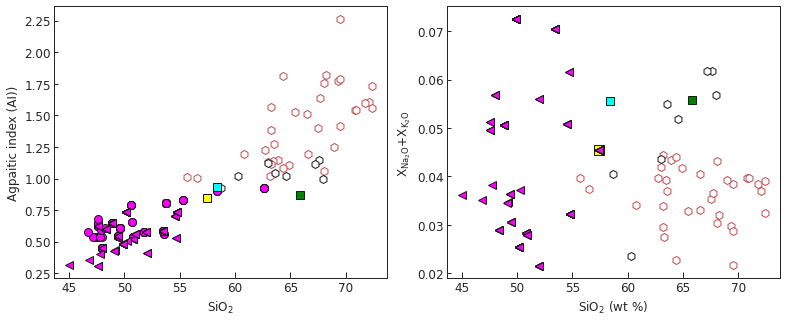

In [19]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (13, 5)) #, sharex=ax1, ax2, ax3, sharey=True) # adjust dimensions of figure here

ax1.plot(Atlas_MIs['SiO2'], Atlas_MIs_AI, 'hr', mfc='white', ms=8)
ax1.plot(Cassidy_MIs['SiO2'], Cassidy_MIs_AI, 'hk', mfc='white', ms=8)
ax1.plot(IM_H2O.loc[IM_H2O['CO2']==0, 'SiO2'], IM_H2O_AI.loc[IM_H2O['CO2']==0],
       'ok', mfc='magenta', ms=8)
ax1.plot(IM_H2O.loc[IM_H2O['CO2']>0, 'SiO2'], IM_H2O_AI.loc[IM_H2O['CO2']>0], '<k', mfc='magenta', ms=8)


ax1.plot(Exp.loc[Exp['Label']=="Bot_2006_MinWater", "SiO2"], Exp_AI.loc[Exp['Label']=="Bot_2006_MinWater"],
         'sk', mfc='yellow', ms=8)
ax1.plot(Exp.loc[Exp['Label']=="King_2002_MinWater", "SiO2"], Exp_AI.loc[Exp['Label']=="King_2002_MinWater"],
         'sk', mfc='cyan', ms=8)
ax1.plot(Exp.loc[Exp['Label']=="Berhens_2004_MinWater", "SiO2"], Exp_AI.loc[Exp['Label']=="Berhens_2004_MinWater"],
         'sk', mfc='green', ms=8)

ax2.plot(Atlas_MIs['SiO2'], Atlas_MIs_A_mol_frac['Na2O_mol_frac']+Atlas_MIs_A_mol_frac['K2O_mol_frac'], 'hr', mfc='white', ms=8)
ax2.plot(Cassidy_MIs['SiO2'], Cassidy_MIs_A_mol_frac['Na2O_mol_frac']+Cassidy_MIs_A_mol_frac['K2O_mol_frac'], 'hk', mfc='white', ms=8)
ax2.plot(Exp.loc[Exp['Label']=="Bot_2006_MinWater", "SiO2"], 
        Exp_A_mol_frac.loc[Exp_A_mol_frac['Label']=="Bot_2006_MinWater", 'K2O_mol_frac']+Exp_A_mol_frac.loc[Exp_A_mol_frac['Label']=="Bot_2006_MinWater", 'Na2O_mol_frac'],
         'sk', mfc='yellow', ms=10)
ax2.plot(Exp.loc[Exp['Label']=="King_2002_MinWater", "SiO2"], 
        Exp_A_mol_frac.loc[Exp_A_mol_frac['Label']=="King_2002_MinWater", 'K2O_mol_frac']
         +Exp_A_mol_frac.loc[Exp_A_mol_frac['Label']=="King_2002_MinWater", 'Na2O_mol_frac'],
         'sk', mfc='cyan', ms=8)
ax2.plot(Exp.loc[Exp['Label']=="Berhens_2004_MinWater", "SiO2"], 
        Exp_A_mol_frac.loc[Exp_A_mol_frac['Label']=="Berhens_2004_MinWater", 'K2O_mol_frac']
         +Exp_A_mol_frac.loc[Exp_A_mol_frac['Label']=="Berhens_2004_MinWater", 'Na2O_mol_frac'],
         'sk', mfc='green', ms=8)
ax2.plot(IM_H2O.loc[IM_H2O['CO2']>0, 'SiO2'], 
         IM_H2O_A_mol_frac.loc[IM_H2O['CO2']>0, 'Na2O_mol_frac']+IM_H2O_A_mol_frac.loc[IM_H2O['CO2']>0, 'K2O_mol_frac'],
          '<k', mfc='magenta', ms=8)

plt.subplots_adjust(left=0.125, bottom=None, right=0.9, top=None, wspace=0.18, hspace=None)
ax1.set_ylabel('Agpaitic index (AI))')
ax1.set_xlabel('SiO$_2$')

ax2.set_ylabel('X$_{Na_{2}O}$+X$_{K_{2}O}$')
ax2.set_xlabel('SiO$_2$ (wt %)')
ax4.set_xlabel('SiO$_2$ (wt %)')
fig.savefig('Andesite_Calibrations2.svg', transparent=True)

In [20]:
meanIM_MgOFeO=np.mean(IM_H2O_A_mol_frac.loc[IM_H2O['CO2']>0, 'MgO_mol_frac']
                      +IM_H2O_A_mol_frac.loc[IM_H2O['CO2']>0, 'FeOt_mol_frac'])
expmeanIM_MgOFeO=np.exp(meanIM_MgOFeO*(-17.1))
expmeanIM_MgOFeO

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.050814176524685756

In [21]:
meanAtlas_MgOFeO=np.mean(Atlas_MIs_A_mol_frac['MgO_mol_frac']+
                         Atlas_MIs_A_mol_frac['FeOt_mol_frac'])
expmeanAtlas_MgOFeO=np.exp(meanAtlas_MgOFeO*(-17.1))
expmeanAtlas_MgOFeO

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.36268543475119236

In [22]:
meanCassidy_MgOFeO=np.mean(Cassidy_MIs_A_mol_frac['MgO_mol_frac']+
                         Cassidy_MIs_A_mol_frac['FeOt_mol_frac'])
expmeanCassidy_MgOFeO=np.exp(meanCassidy_MgOFeO*(-17.1))
expmeanCassidy_MgOFeO

0.438683985674892

In [23]:
meanIM=np.mean(IM_H2O_AI.loc[IM_H2O['CO2']>0])
expmeanIM=np.exp(meanIM*(4.4))
expmeanIM

14.783662029993733

In [24]:
expmeanAtlas_MgOFeO/expmeanIM_MgOFeO

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


7.137485236526428

In [25]:
expmeanCassidy_MgOFeO/expmeanIM_MgOFeO

8.633102328476726

In [26]:
meanAtlas=np.mean(Atlas_MIs_AI)
expmeanAtlas=np.exp(meanAtlas*(4.4))
expmeanAtlas

511.6812532622311

In [27]:
meanCassidy=np.mean(Cassidy_MIs_AI)
expmeanCassidy=np.exp(meanCassidy*(4.4))
expmeanCassidy

100.74736051276537

In [28]:
meanCassidy

1.0483218186588967

In [29]:
expmeanCassidy/expmeanIM

6.814777036187973

In [30]:
expmeanAtlas/expmeanIM

34.61126561362875